<a href="https://colab.research.google.com/github/mkosaka1/Speech_Emotion_Recognition/blob/master/4.%20Transfer_Learning%20-%20Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wG2vRbLPDlZKkDRzQALDjvcDf6zNatAI2d7krAVkqo9KHb0F6JkNj4
Mounted at /content/drive


In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling2D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical
from glob import glob
import cv2
from sklearn.utils import shuffle


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# READ IN AUDIO FILES 
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

In [ ]:
dicts={'01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}

In [ ]:
path_main=audio

In [ ]:
folders_main=os.listdir(path_main)

FileNotFoundError: ignored

# Log-Mel Spectrogram

In [ ]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

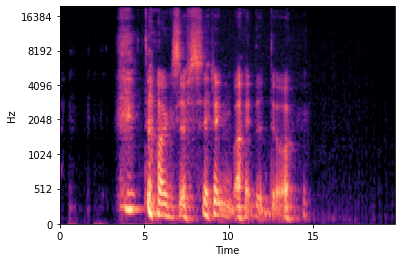

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');


In [ ]:
import re
counter=0
for folders in folders_main :
    path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/Users/murielkosaka/Desktop/capstone_project/audio/sorted_data/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Noise

In [ ]:
# FUNCTION TO ADD WHITE NOISE
def noise(y):
    noise_amp = 0.05*np.random.uniform()*np.amax(y)   
    y = y.astype('float64') + noise_amp * np.random.normal(size=y.shape[0])
    return y

In [ ]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

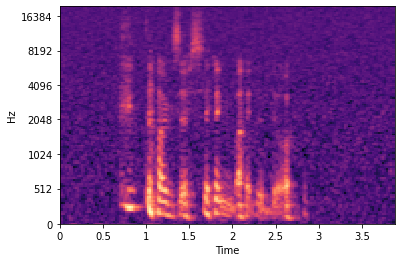

In [ ]:
y = noise(y)
y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
db_spec = librosa.power_to_db(y)
librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/Users/murielkosaka/Desktop/capstone_project/audio/noise/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y = noise(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Stretch

In [ ]:
# FUNCTION TO STRETCH THE SOUND
def stretch(y, rate=0.8):
    data = librosa.effects.time_stretch(y, rate)
    return data

In [ ]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

In [ ]:
y=yt

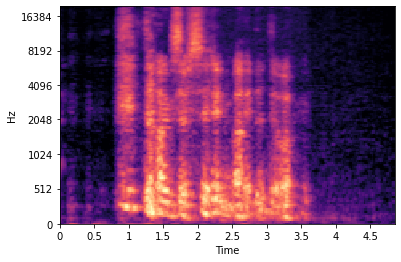

In [ ]:
y= stretch(y)
y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
db_spec = librosa.power_to_db(y)
librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');

16 angry
16 fearful
16 fearful
16 angry
16 disgust
16 sad
16 sad
16 disgust
16 surprised
16 surprised
16 happy
16 happy
16 calm
16 neutral
16 calm
16 happy
16 happy
16 calm
16 calm
16 neutral
16 fearful
16 angry
16 angry
16 fearful
16 sad
16 disgust
16 disgust
16 sad
16 surprised
16 surprised
16 calm
16 neutral
16 calm
16 happy
16 happy
16 disgust
16 sad
16 sad
16 disgust
16 angry
16 fearful
16 fearful
16 angry
16 surprised
16 surprised
16 sad
16 disgust
16 disgust
16 sad
16 fearful
16 angry
16 angry
16 fearful
16 surprised
16 surprised
16 neutral
16 calm
16 calm
16 happy
16 happy
11 neutral
11 calm
11 calm
11 happy
11 happy
11 sad
11 disgust
11 disgust
11 sad
11 fearful
11 angry
11 angry
11 fearful
11 surprised
11 surprised
11 disgust
11 sad
11 sad
11 disgust
11 angry
11 fearful
11 fearful
11 angry
11 surprised
11 surprised
11 calm
11 neutral
11 calm
11 happy
11 happy
11 fearful
11 angry
11 angry
11 fearful
11 sad
11 disgust
11 disgust
11 sad
11 surprised
11 surprised
11 happy
11 happ

15 neutral
15 calm
15 happy
15 happy
23 disgust
23 sad
23 sad
23 disgust
23 angry
23 fearful
23 fearful
23 angry
23 surprised
23 surprised
23 calm
23 neutral
23 calm
23 happy
23 happy
23 neutral
23 calm
23 calm
23 happy
23 happy
23 sad
23 disgust
23 disgust
23 sad
23 fearful
23 angry
23 angry
23 fearful
23 surprised
23 surprised
23 happy
23 happy
23 calm
23 neutral
23 calm
23 angry
23 fearful
23 fearful
23 angry
23 disgust
23 sad
23 sad
23 disgust
23 surprised
23 surprised
23 fearful
23 angry
23 angry
23 fearful
23 sad
23 disgust
23 disgust
23 sad
23 surprised
23 surprised
23 happy
23 happy
23 calm
23 calm
23 neutral
24 happy
24 happy
24 calm
24 calm
24 neutral
24 fearful
24 angry
24 angry
24 fearful
24 sad
24 disgust
24 disgust
24 sad
24 surprised
24 surprised
24 angry
24 fearful
24 fearful
24 angry
24 disgust
24 sad
24 sad
24 disgust
24 surprised
24 surprised
24 happy
24 happy
24 calm
24 neutral
24 calm
24 sad
24 disgust
24 disgust
24 sad
24 fearful
24 angry
24 angry
24 fearful
24 su

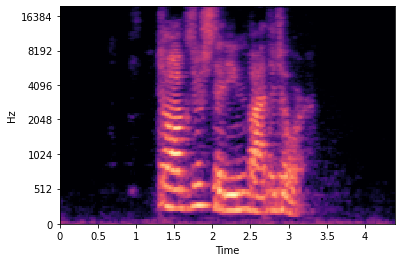

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/Users/murielkosaka/Desktop/capstone_project/audio/stretch/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y= stretch(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Speed N Pitch

In [ ]:
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
y, sr = librosa.load(fname)
yt,_=librosa.effects.trim(y)

In [ ]:
y=yt

In [ ]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(y):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(y),speed_fac),np.arange(0,len(y)),y)
    minlen = min(y.shape[0], tmp.shape[0])
    y *= 0
    y[0:minlen] = tmp[0:minlen]
    return y

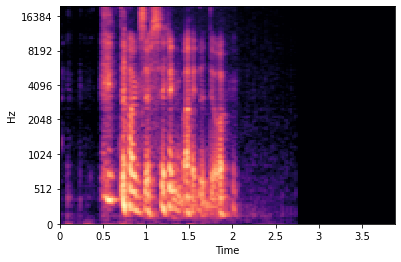

In [ ]:
y= speedNpitch(y)
y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
db_spec = librosa.power_to_db(y)
librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/Users/murielkosaka/Desktop/capstone_project/audio/speednpitch/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y= speedNpitch(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

In [ ]:
import re
counter=0
for folders in folders_main :
    path_in='/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/{0}'.format(folders)
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print (numbers[6],emotion)
        path_save='/Users/murielkosaka/Desktop/capstone_project/audio/speednpitch/{0}/{1}.jpeg'.format(emotion,file)
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        y= speedNpitch(y)
        y = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        db_spec = librosa.power_to_db(y)
        librosa.display.specshow(db_spec, y_axis='mel', fmax=20000, x_axis='time');
        plt.savefig(path_save)

# Transfer Learning

## Attach labels to Stretch

In [ ]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for labels in os.listdir(directory): 
        if labels == 'angry': 
            label = 'angry'
        elif labels == 'calm':
            label = 'calm'
        elif labels == 'disgust':
            label = 'disgust'
        elif labels == 'fearful':
            label = 'fearful'
        elif labels == 'happy':
            label = 'happy'
        elif labels == 'neutral':
            label = 'neutral'
        elif labels == 'sad':
            label = 'sad'
        elif labels == 'surprised':
            label = 'surprised'
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(75,75)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            # image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=200) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {'angry':'angry', 'calm':'calm', 'disgust':'disgust', 'fearful':'fearful', 'happy':'happy', 'neutral':'neutral','sad':'sad','surprised':'surprised'}
    
    return labels[class_code]

In [ ]:
Images, Labels = get_images('/content/drive/My Drive/stretch/') #Extract the training images from the folders.


KeyboardInterrupt: ignored

# Process Images for Transfer Learning

In [ ]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(Images, Labels, test_size=0.3,random_state=22, stratify=Labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.3,random_state=22,stratify=y_model)


In [ ]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

X_train=np.array(X_train)/255
# y_train = to_categorical(lb.fit_transform(y_train),num_classes=8)

X_test=np.array(X_test)/255
# y_test = to_categorical(lb.fit_transform(y_test),num_classes=8)

X_val=np.array(X_val)/255
# y_val = to_categorical(lb.fit_transform(y_val),num_classes=8)



y_val=np_utils.to_categorical(lb.fit_transform(y_val))
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
X_test.shape

(1728, 75, 75, 3)

In [ ]:
X_train.shape

(2822, 75, 75, 3)

In [ ]:
X_val.shape

(1210, 75, 75, 3)

In [ ]:
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(lb.classes_)

AttributeError: ignored

# VGG16

In [ ]:
from keras import applications

model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (75, 75, 3),pooling='avg')

In [ ]:
# freezing the layers 
for layer in model.layers[:17]:
    layer.trainable = False


#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

In [ ]:
predictions = Dense(8, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)     

In [ ]:
history = model_final.fit(X_train,y_trainHot, batch_size=32,epochs= 10, validation_data= (X_val,y_valHot))


Epoch 1/10
89/89 [==============================] - 214s 2s/step - loss: 2.1124 - accuracy: 0.1269 - val_loss: 2.0691 - val_accuracy: 0.1207
Epoch 2/10
89/89 [==============================] - ETA: 0s - loss: 2.0703 - accuracy: 0.1396

KeyboardInterrupt: ignored

In [ ]:
60,55

In [ ]:
train_data_dir = "audio/data/train"
val_data_dir = "audio/data/validation"
test_data_dir = "audio/data/test"
category_names = sorted(os.listdir('audio/data/train/'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'audio/data/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")


In [ ]:
for subdir, dirs, files in os.walk('data/train'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break


In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
img_height, img_width = 224,224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))


In [ ]:
for layer in conv_base.layers[:-13]:
    layer.trainable = False


In [ ]:
from tensorflow.python.keras import layers, models, Model, optimizers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()


In [ ]:
#Number of images to load at each iteration
batch_size = 32
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")
print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)
print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)


In [ ]:
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

learning_rate = 5e-5
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])


In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=val_generator,
                              )